# Single-Event, Nonparametric Event-Time DiD Analysis

$$
abnormal\_return_{it} = \alpha + \sum_{k \ne -1} \theta_k \cdot 1(event\_time = k)
+ \sum_{k \ne -1} \beta_k \cdot 1(event\_time = k) \times Treatment_i + \gamma_i + \varepsilon_{it}
$$


In [17]:
import pandas as pd

# Load data
data = pd.read_csv("final_df.csv")

# Convert 'Date' and 'event_date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])

# # Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

# Remove the day before the event (k = -1) as the base period
df_reg = data[data["event_time"] != -1]  # The last time point “not affected by policy”

# Remove 'QQQ' as a control group (we want only firm-level analysis)

df_reg = df_reg[df_reg["ticker"] != "QQQ"]

# Make sure 'event_time' is a categorical variable
df_reg["event_time"] = df_reg["event_time"].astype(float).astype(int).astype("category")


# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]]

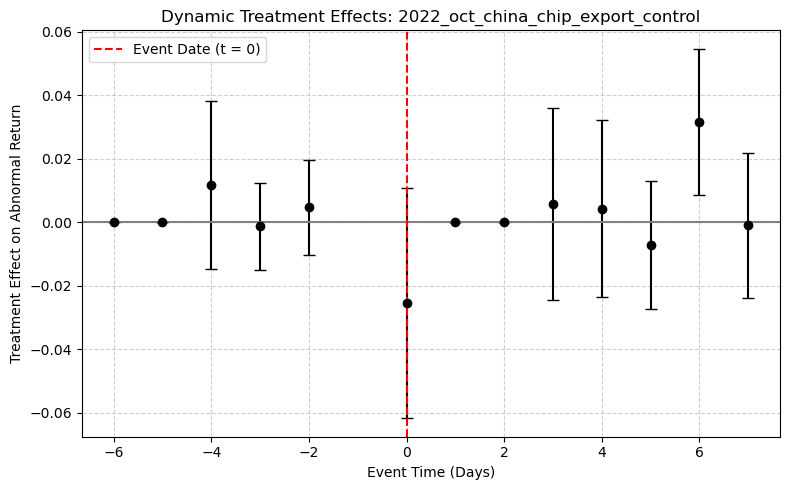


=== Event: 2022_oct_china_chip_export_control ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


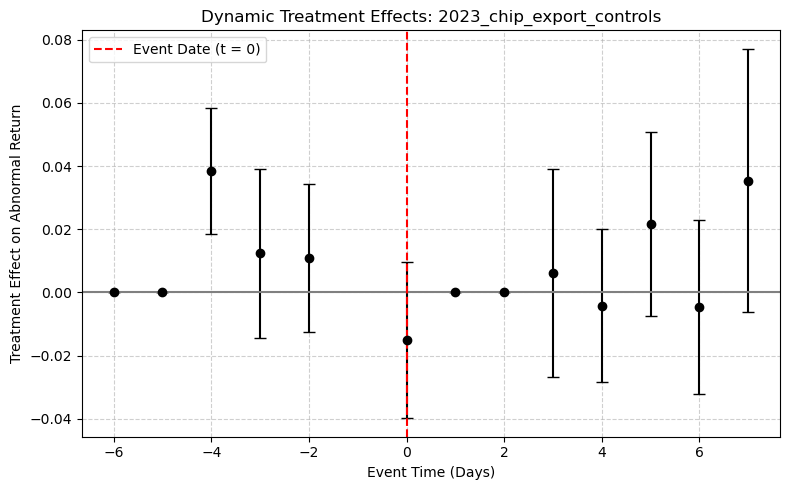


=== Event: 2023_chip_export_controls ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


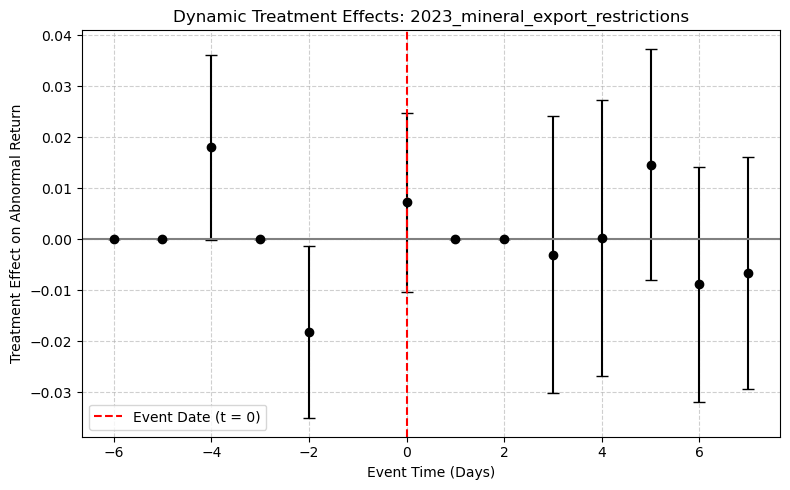


=== Event: 2023_mineral_export_restrictions ===
Total observations used: 144
Treatment group size: 72
Control group size: 72
Tickers in regression: 16


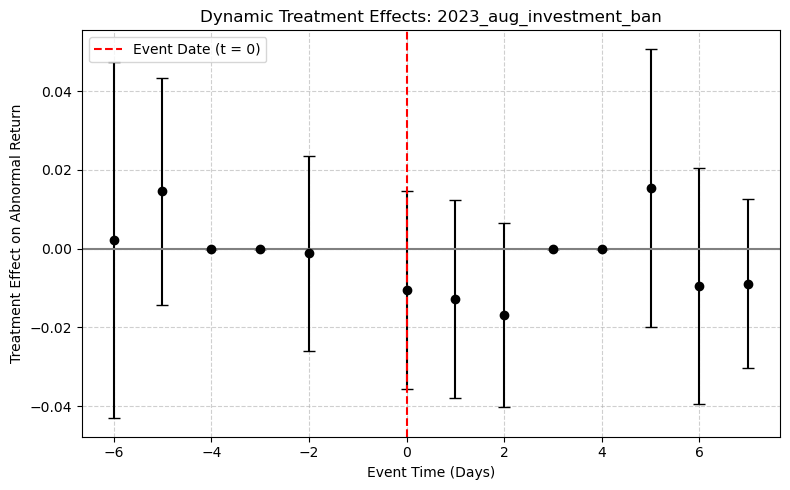


=== Event: 2023_aug_investment_ban ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


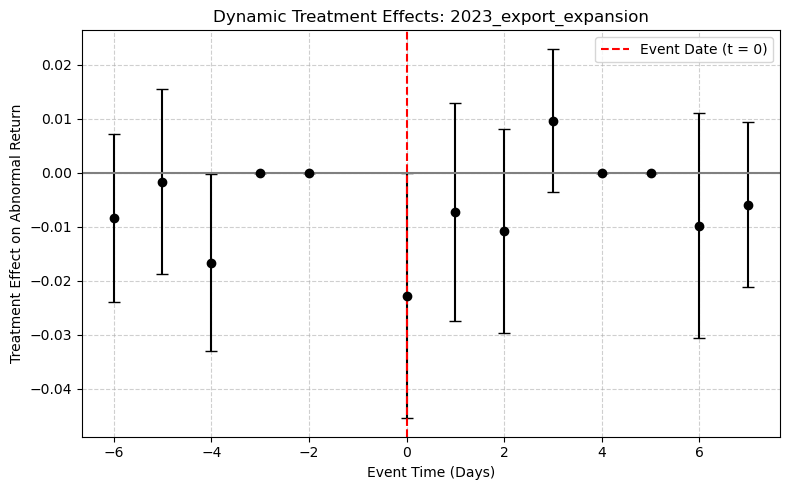


=== Event: 2023_export_expansion ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


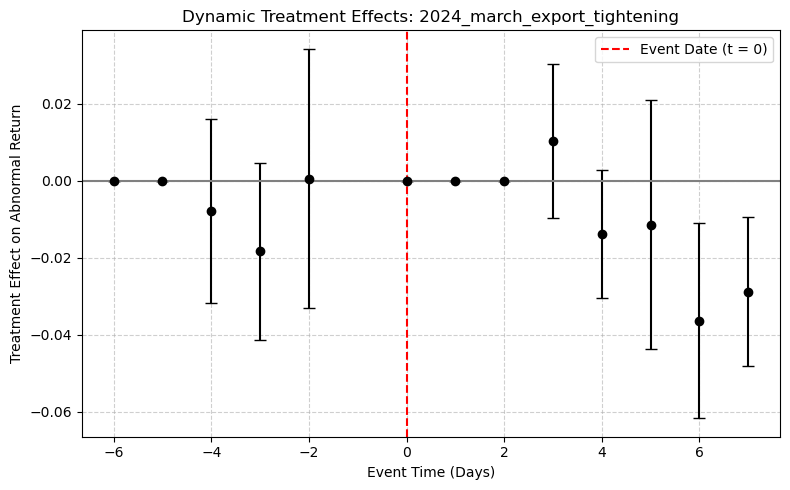


=== Event: 2024_march_export_tightening ===
Total observations used: 144
Treatment group size: 72
Control group size: 72
Tickers in regression: 16


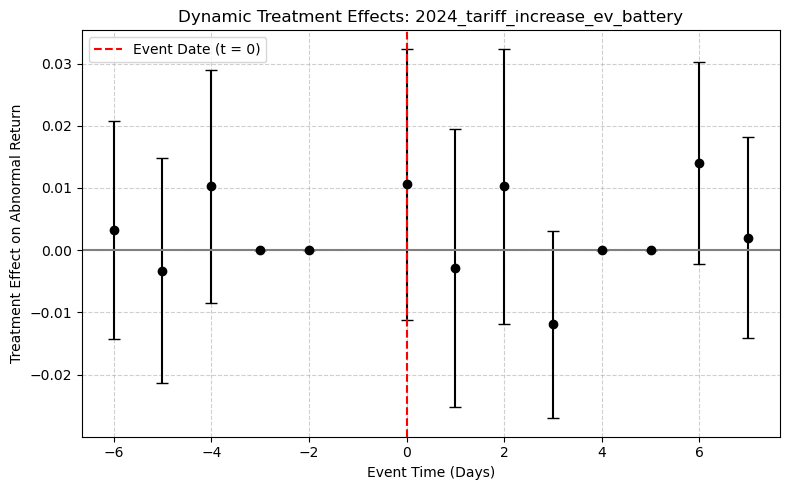


=== Event: 2024_tariff_increase_ev_battery ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


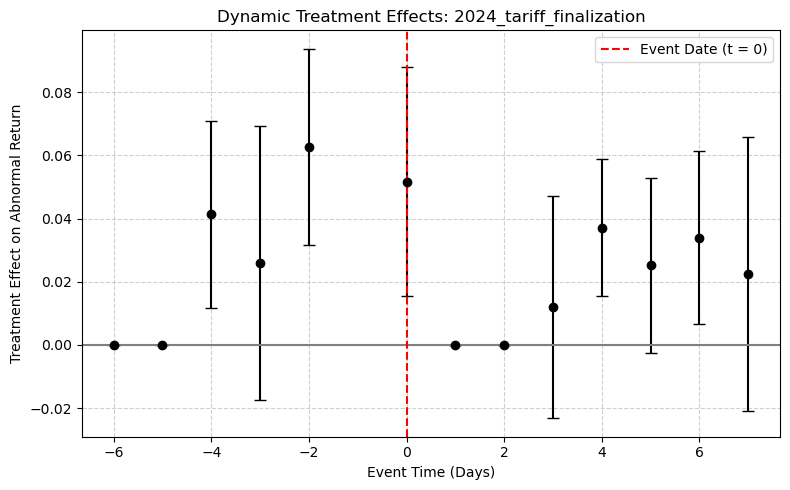


=== Event: 2024_tariff_finalization ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


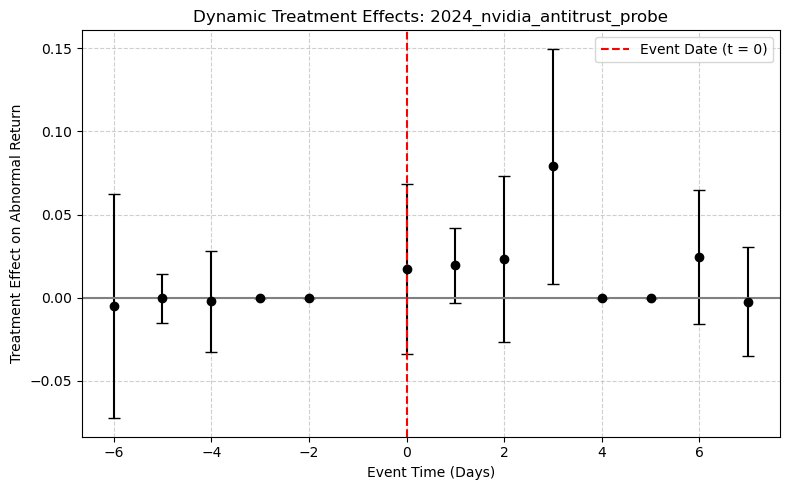


=== Event: 2024_nvidia_antitrust_probe ===
Total observations used: 160
Treatment group size: 80
Control group size: 80
Tickers in regression: 16


In [18]:

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

expected_levels = [k for k in range(-7, 8) if k != -1]
df_reg["event_time"] = pd.Categorical(df_reg["event_time"], categories=expected_levels)

event_ids = df_reg["event_id"].unique()

for event in event_ids:
    df_event = df_reg[df_reg["event_id"] == event].copy()

    if df_event["Treatment"].nunique() < 2:
        print(f"Skipping event {event} due to lack of group variation.")
        continue

    model = smf.ols(
        formula="abnormal_return ~ C(event_time) * Treatment + C(ticker)", data=df_event
    ).fit(cov_type="cluster", cov_kwds={"groups": df_event["ticker"]})

    coef = model.params
    conf = model.conf_int()

    treat_effect = coef[
        coef.index.str.contains(r"C\(event_time\)\[T\.-?\d+\]:Treatment")
    ].reset_index()
    treat_effect.columns = ["term", "coef"]
    conf_treat = conf.loc[treat_effect["term"]]
    treat_effect["lower"] = conf_treat[0].values
    treat_effect["upper"] = conf_treat[1].values
    treat_effect["event_time"] = (
        treat_effect["term"].str.extract(r"\[T\.?(-?\d+)\]")[0].astype(int)
    )
    treat_effect = treat_effect.sort_values("event_time")

    plt.figure(figsize=(8, 5))
    plt.errorbar(
        treat_effect["event_time"],
        treat_effect["coef"],
        yerr=[
            treat_effect["coef"] - treat_effect["lower"],
            treat_effect["upper"] - treat_effect["coef"],
        ],
        fmt="o",
        capsize=4,
        color="black",
    )
    plt.axhline(0, color="gray", linestyle="-")
    plt.axvline(0, color="red", linestyle="--", label="Event Date (t = 0)")
    plt.title(f"Dynamic Treatment Effects: {event}")
    plt.xlabel("Event Time (Days)")
    plt.ylabel("Treatment Effect on Abnormal Return")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    print(f"\n=== Event: {event} ===")
    print(f"Total observations used: {len(df_event)}")
    print("Treatment group size:", df_event["Treatment"].sum())
    print("Control group size:", len(df_event) - df_event["Treatment"].sum())
    print("Tickers in regression:", df_event['ticker'].nunique())
